In [ ]:
# # save_labels.py
# from ultralytics import YOLO
# import os

# # Load the model
# model = YOLO("yolo11n.pt")  # or your custom model

# # Get class names
# class_names = model.names  # dict: {0: 'person', 1: 'bicycle', ...}

# # Save to file
# # os.makedirs("mobile_yolov8n", exist_ok=True)
# with open("labels.txt", "w") as f:
#     for i in range(len(class_names)):
#         f.write(class_names[i] + "\n")

# print("Saved labels.txt with 80 COCO classes")

Saved labels.txt with 80 COCO classes



image 1/1 d:\FCDS\Graduation Project\yolov11n model\bus.jpg: 640x480 4 persons, 1 bus, 75.4ms
Speed: 2.1ms preprocess, 75.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Results saved to D:\FCDS\Graduation Project\yolov11n model\runs\detect\predict2


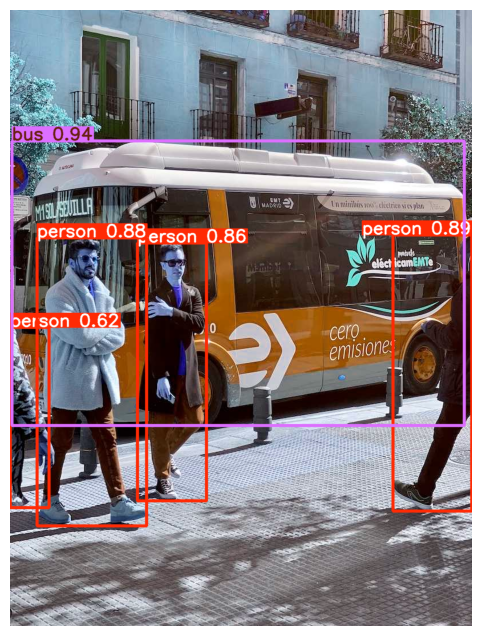

In [1]:
# quick_detect.py
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load model
model = YOLO("yolo11n.pt")  # automatically downloads if not present

# Path to input image
img_path = "bus.jpg"  # change to one of your val images:  000000068093

# Run prediction
results = model.predict(source=img_path, conf=0.25, save=True)  # device=0 uses GPU

# --- Display the predicted image inline ---
plt.figure(figsize=(8, 8))
plt.imshow(results[0].plot())
plt.axis("off")
plt.show()

In [ ]:
from ultralytics import YOLO

# # Load the YOLO11 model
# model = YOLO("yolo11n.pt")

# # Export the model to TFLite format
# model.export(format="tflite")  # creates 'yolo11n_float32.tflite'

# Load the exported TFLite model
tflite_model = YOLO("yolo11n_float32.tflite", task="detect")

# Run inference
# results = tflite_model("https://ultralytics.com/images/bus.jpg")
results = tflite_model("bus.jpg")

Loading yolo11n_float32.tflite for TensorFlow Lite inference...

image 1/1 d:\FCDS\Graduation Project\yolov11n model\bus.jpg: 640x640 4 persons, 1 bus, 124.3ms
Speed: 3.0ms preprocess, 124.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


In [4]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="yolo11n_float32.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("INPUT DETAILS:")
for d in input_details:
    print(d["name"], d["shape"], d["dtype"])

print("\nOUTPUT DETAILS:")
for d in output_details:
    print(d["name"], d["shape"], d["dtype"])

INPUT DETAILS:
images [  1 640 640   3] <class 'numpy.float32'>

OUTPUT DETAILS:
Identity [   1   84 8400] <class 'numpy.float32'>


In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2  # if using OpenCV on mobile (or use platform's image loader)

# ================== 1. Load TFLite model ==================
interpreter = tf.lite.Interpreter(model_path="yolo11n_float32.tflite")
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Model expects input shape: [1, 640, 640, 3], float32
INPUT_SIZE = (640, 640)

# ================== 2. COCO Class Names (YOLO11 uses same 80 classes) ==================
COCO_CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

# ================== 3. Preprocessing Function ==================
def preprocess_image(image_path_or_cv2_img, input_size=INPUT_SIZE):
    """
    Input: either file path (str) or cv2 image (numpy array BGR)
    Output: preprocessed tensor ready for TFLite [1,640,640,3] float32
    """
    if isinstance(image_path_or_cv2_img, str):
        img = cv2.imread(image_path_or_cv2_img)
    else:
        img = image_path_or_cv2_img

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Resize + Letterbox (keeps aspect ratio like Ultralytics)
    r = min(input_size[0] / h, input_size[1] / w)
    new_h, new_w = int(h * r), int(w * r)
    img_resized = cv2.resize(img_rgb, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create 640x640 canvas with gray padding (114,114,114)
    canvas = np.full((input_size[0], input_size[1], 3), 114, dtype=np.uint8)
    top = (input_size[0] - new_h) // 2
    left = (input_size[1] - new_w) // 2
    canvas[top:top+new_h, left:left+new_w] = img_resized

    # Normalize to [0,1]
    input_data = canvas.astype(np.float32) / 255.0

    # Add batch dimension
    input_data = np.expand_dims(input_data, axis=0)  # shape: (1,640,640,3)

    return input_data, (r, top, left, w, h)  # scaling info for post-processing


# ================== 4. Post-processing (NMS + Counting) ==================
def postprocess_predictions(output_data, scale_info, conf_threshold=0.25, iou_threshold=0.45):
    """
    YOLO11 TFLite output: [1, 84, 8400] → 84 = 4(bbox) + 80(classes)
    """
    r, top, left, orig_w, orig_h = scale_info
    predictions = np.squeeze(output_data).T  # → (8400, 84)

    boxes = predictions[:, :4]
    scores = predictions[:, 4:]
    
    class_ids = np.argmax(scores, axis=1)
    confidences = scores[np.arange(len(scores)), class_ids]

    # Convert from [cx, cy, w, h] (normalized) → [x1,y1,x2,y2] in padded image
    cx, cy, w, h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    x1 = (cx - w/2) * 640
    y1 = (cy - h/2) * 640
    x2 = (cx + w/2) * 640
    y2 = (cy + h/2) * 640

    # Scale back to original image coordinates
    x1 = (x1 - left) / r
    y1 = (y1 - top) / r
    x2 = (x2 - left) / r
    y2 = (y2 - top) / r

    boxes_scaled = np.stack([x1, y1, x2, y2], axis=1)
    boxes_scaled = np.clip(boxes_scaled, 0, max(orig_w, orig_h))

    # Apply confidence threshold
    mask = confidences >= conf_threshold
    boxes_scaled = boxes_scaled[mask]
    confidences = confidences[mask]
    class_ids = class_ids[mask]

    # NMS
    indices = cv2.dnn.NMSBoxes(
        bboxes=boxes_scaled.tolist(),
        scores=confidences.tolist(),
        score_threshold=conf_threshold,
        nms_threshold=iou_threshold
    )

    if len(indices) > 0:
        indices = indices.flatten()
        final_boxes = boxes_scaled[indices]
        final_scores = confidences[indices]
        final_classes = class_ids[indices]
    else:
        final_boxes, final_scores, final_classes = [], [], []

    # Count objects
    from collections import Counter
    count_dict = Counter(COCO_CLASSES[idx] for idx in final_classes)

    # Generate human readable text
    result_text = []
    for obj_name, cnt in count_dict.items():
        if cnt == 1:
            result_text.append(f"There is 1 {obj_name}")
        else:
            result_text.append(f"There are {cnt} {obj_name}s")

    return "\n".join(result_text), final_boxes, final_scores, final_classes


# ================== 5. Full Inference Function (One Call) ==================
def detect_objects(image_path_or_cv2_img, conf=0.25):
    # Preprocess
    input_tensor, scale_info = preprocess_image(image_path_or_cv2_img)

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Postprocess
    text_result, boxes, scores, classes = postprocess_predictions(output_data, scale_info, conf_threshold=conf)

    return text_result, boxes, scores, classes


# ================== TEST IT ==================
if __name__ == "__main__":
    result_text, boxes, scores, classes = detect_objects("bus.jpg", conf=0.25)
    print("\n" + "="*50)
    print("FINAL RESULT:")
    print("="*50)
    print(result_text)


FINAL RESULT:
There is 1 bus
There are 4 persons
